# Курсовая работа

Меньшиков Илья, ПМ21-3

### Тема:
**Методы машинного обучения для поиска паттернов в видео.**

## План работы:


1. Загрузка, установка и необходимые функции
    - Перед началом работы
    - Загрузка видео
    - Что такое YOLO?
    - Установка YOLOv8
    - Установка ByteTrack
    - Установка Roboflow Supervision
    - Функции отслеживания
2. Загрузка предварительно обученной модели YOLOv8
    - Прогнозирование и аннотирование отдельных кадров
    - Прогнозирование и аннотирование всего видео
    - Вывод части результата для наглядности
3. Обучение модели yolov8 на основе пользовательского набора данных
    - Загрузка и аннотация данных
    - Обучение модели
    - Тесты модели
    - Проверка модели на одном кадре
    - Применение модели для всего видео
    - Вывод части результата
4. Вывод




# Загрузка, установка и необходимые функции



[Ссылка на ноутбук в google colab](https://colab.research.google.com/drive/1Mch-pkAPPmkmPE2LQ7_3T-OdcQGss4wz?usp=sharing)

[Ссылка на папку Google Drive со всеми данными этой курсовой работы](https://drive.google.com/drive/folders/1Uf6ZvU-gQWQR9Zvb2buIf-fVqtqf92Ex?usp=share_link)

**Нужно использовать GPU**

Я использую Google Colab. Перед началом нужно зайти в "Среда выполнения" -> "Сменить среду выполнения" и установить для него значение "GPU", а затем нажать "Сохранить". Это гарантирует, что ноутбук будет использовать графический процессор для ускорения времени обучения модели.

Чтобы убедиться, что есть доступ к GPU я использую команду `!nvidia-smi`

In [ ]:
!nvidia-smi

Fri Apr 21 19:53:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Подключение библиотеки Google Colab и присоединение Google Drive к текущей сессии

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HOME = '/content/drive/MyDrive/coursework_1'

## Загрузка видео

[Ссылка на видео, загруженное на Google Drive](https://drive.google.com/file/d/1KNCQA5BG7UNPi9TqEnbTZ3r2rpssqP0o/view?usp=share_link)

In [ ]:
%cd {HOME}

# загрузка видео с Google Drive по id
!gdown 1KNCQA5BG7UNPi9TqEnbTZ3r2rpssqP0o

/content/drive/MyDrive/coursework_1
Downloading...
From: https://drive.google.com/uc?id=1KNCQA5BG7UNPi9TqEnbTZ3r2rpssqP0o
To: /content/drive/MyDrive/coursework_1/highway.mp4
100% 18.8M/18.8M [00:00<00:00, 42.1MB/s]


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/highway.mp4"

##Что такое **YOLO**?

**YOLO (абр. от “You Only Look Once” (“Стоит только раз взглянуть”))** - это современный метод глубокого обучения для задач обнаружения объектов (как детекции, так и сегментации), в основе которого лежат сверточные нейронные сети.

Первая версия алгоритма была разработана в 2016 и на состояние начала 2023 года вышло уже, как минимум, 8 общепринятых модификаций данной модели, каждая из которых имеет свои преимущества и недостатки.

Если не вдаваться в подробности, то ключевая идея работы YOLO состоит в том, что исходное изображение разбивается на мелкие секции (они еще называются клетки/сэмплы/тайлы) размером SxS пикселей (для различных версий YOLO параметр S может быть различным).

Каждая полученная становится потенциальным bounding_box’ом. То есть внутри каждой клетки по специальному методу "рисуются" несколько рамок для определения объекта различной ширины и высоты (а также возможно добавление поворота), позиции этих рамок вычисляются относительно центра клетки.

На полученных секциях с помощью специализированной архитектуры сверточной нейронной сети строится карта распределения вероятности каждого из классов в каждой из секций, то есть в каждой из секций определяется вероятность наличия каждого из классов. После результаты специализированным образом совмещаются и мы получаем решение задачи детекции - нужные нам bounding box’ы.

Главная особенность архитектуры YOLO - это скорость! YOLO позволяет распознавать объекты на изображении в режиме реального времени. Принцип работы YOLO подразумевает ввод сразу всего изображения, которое проходит через сверточную нейронную сеть только один раз. Именно поэтому он называется “Стоит только раз взглянуть”. В других алгоритмах этот процесс происходит многократно, то есть изображение проходит через CNN снова и снова. Так что YOLO обладает преимуществом высокоскоростного обнаружения объектов, чем не могут похвастать другие алгоритмы.

После выбора семейства архитектур, нужно еще выбрать версию модели. Например, для YOLO на весну 2023 последней является версия YOLOv8. Отличия между всеми версиями модели можно посмотреть в [этой статье](https://hashdork.com/ru/yolo/), в которой приведено общее сравнение первых 5-ти версий архитектуры.

Затем необходимо выбрать реализацию этой модели. Я буду использовать [репозиторий с реализацией YOLOv8](https://github.com/ultralytics/ultralytics) на фреймворке для глубокого обучения PyTorch от компании [Ultralitics](https://ultralytics.com/).


## Установка YOLOv8

YOLOv8 все еще находится в стадии интенсивной разработки. Кардинальные изменения вносятся почти еженедельно.

In [ ]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.8/529.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 22.5 MB/s eta 0:00:00


In [ ]:
import ultralytics
ultralytics.__version__

'8.0.84'

## Установка ByteTrack

[**ByteTrack**](https://github.com/ifzhang/ByteTrack) - это простой, быстрый и надежный мультиобъектный трекер. Алгоритм был разработан компанией Megvii и является одним из наиболее эффективных решений для задачи отслеживания объектов на видео.

Большинство методов трекинга получают идентификационные данные, связывая detection boxes (рамки обнаружения) с показателями, превышающими пороговое значение. Объекты с низкими показателями обнаружения (confidence) попросту игнорируются, что приводит к значительной утрате истинных объектов и фрагментации траекторий. BYTE является эффективным методом соотнесения, который использует в процессе сопоставления все detection boxes – как с высокими, так и с низкими показателями.

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

/content/drive/MyDrive/coursework_1
fatal: destination path 'ByteTrack' already exists and is not an empty directory.
/content/drive/MyDrive/coursework_1/ByteTrack


In [ ]:
# исправление ошибки https://github.com/roboflow/notebooks/issues/80

!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

# Аргументы команды s/onnx==1.8.1/onnx==1.9.0/g означают следующее:
# - s/ - заменить
# - /g - глобальная замена

In [ ]:
!pip3 install -r requirements.txt -q
!python3 setup.py develop -q
!pip install cython_bbox -q
!pip install onemetric -q

from IPython import display
display.clear_output()

import sys
sys.path.append(f"{HOME}/ByteTrack")

import yolox
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
yolox.__version__

In [ ]:
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25 # порог вероятности для отслеживания объекта
    track_buffer: int = 30 # количество кадров, в течение которых объект отслеживается
    match_thresh: float = 0.8 # порог перекрытия объектов для сопоставления треков
    aspect_ratio_thresh: float = 3.0 # порог соотношения сторон для отбора объектов
    min_box_area: float = 1.0 # минимальная площадь бокса объекта
    mot20: bool = False # флаг, указывающий на использование датасета MOT20

## Установка Roboflow Supervision

[**Roboflow Supervision**](https://roboflow.github.io/supervision/) - это функция платформы Roboflow, которая предназначена для облегчения процесса разметки данных для обучения нейронных сетей компьютерного зрения. Она позволяет пользователям быстро и точно создавать аннотации для изображений, используя различные инструменты, такие как рамки и маски. Благодаря использованию Roboflow Supervision процесс разметки данных становится более эффективным и удобным, что может сократить время, необходимое для обучения нейронных сетей и улучшить их точность и производительность.

In [ ]:
!pip install supervision==0.1.0 -q

import supervision
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
supervision.__version__

'0.1.0'

## Функции отслеживания

Нужно вручную сопоставлять ограничивающие рамки, полученные от нашей модели, с рамками, созданными трекером.

In [ ]:
from typing import List
import numpy as np

In [ ]:
# преобразование в формат, который может быть использован функцией match_detections_with_tracks
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))

In [ ]:
# преобразует List[STrack] в формат, который может быть использован функцией match_detections_with_tracks
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)

In [ ]:
# сопоставляет ограничительные рамки с прогнозами
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

# Загрузка предварительно обученной модели YOLOv8

In [ ]:
MODEL = "yolov8x.pt"

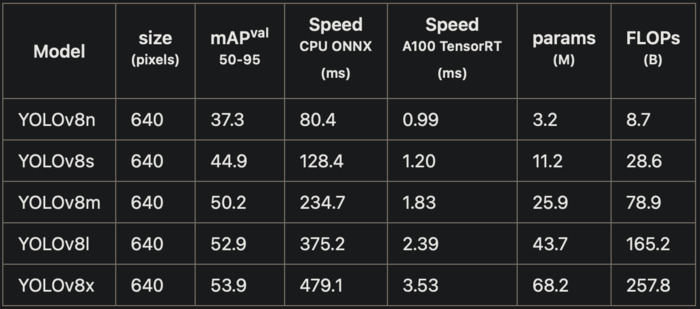

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse() # позволяет оптимизировать модель YOLO, чтобы уменьшить количество операций и ускорить процесс работы модели.

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


## Прогнозирование и аннотирование отдельных кадров

In [ ]:
# Словарь class_id:class_name
CLASS_NAMES_DICT = model.model.names
# 2-car, 3-motorcycle, 5-bus, 7-truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 5 cars, 74.1ms
Speed: 0.6ms preprocess, 74.1ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 640)


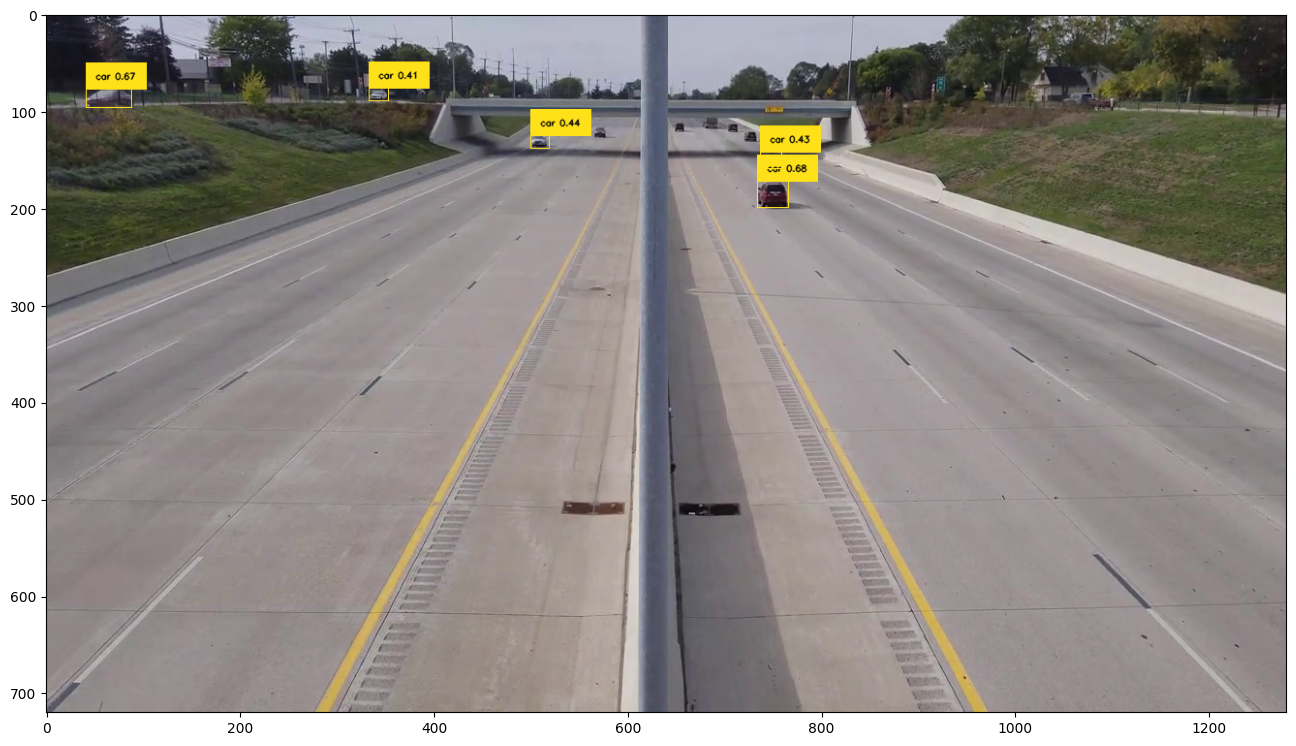

In [ ]:
# генератор кадров
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# ограничивающие рамки
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.3)

# получение первого кадра в видео
iterator = iter(generator)
frame = next(iterator)

# предикт модили одного кадра и перевод в supervision Detections
results = model(frame)

detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# изменение отображение меток
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# аннотация и отображение рамки
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Прогнозирование и аннотирование всего видео

In [ ]:
LINE_START = Point(70, 300)
LINE_END = Point(1200, 300)

TARGET_VIDEO_PATH = f"{HOME}/highway-result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=3537)

In [ ]:
from tqdm.notebook import tqdm


byte_tracker = BYTETracker(BYTETrackerArgs())
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# создание генератора кадров
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

line_counter = LineCounter(start=LINE_START, end=LINE_END)

# создание экземпляров BoxAnnotator и LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.3)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=1, text_scale=0.5)

# открытие видео
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # цикл по кадрам видео
    for frame in tqdm(generator, total=video_info.total_frames):
        # предсказание модели на одном кадре и преобразование в supervision
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # фильтрация обнаружений с нежелательными классами
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # отслеживание обнаружений
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # фильтрация
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # изменение отображение меток
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # обновление счетчика строк
        line_counter.update(detections=detections)

        # аннотация и отображение кадра
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)
display.clear_output()

[Ссылка на результат, загруженный на Google Drive](https://drive.google.com/file/d/1LtrHdRUAUKaOMYjeszuRHY40wc8AR9L2/view?usp=share_link)

## Вывод части результата для наглядности

In [ ]:
# создание нового обрезанного видео
!pip install moviepy -q
from moviepy.video.io.VideoFileClip import VideoFileClip

video_path = "/content/drive/MyDrive/coursework_1/highway-result.mp4"
video = VideoFileClip(video_path).subclip(0, 3)  # обрезаем видео с 0 по 3 секунду

output_path = "/content/drive/MyDrive/coursework_1/highway-result-cut.mp4"
video.write_videofile(output_path)

Moviepy - Building video /content/drive/MyDrive/coursework_1/highway-result-cut.mp4.
Moviepy - Writing video /content/drive/MyDrive/coursework_1/highway-result-cut.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/coursework_1/highway-result-cut.mp4


In [ ]:
#создание gif из mp4
from moviepy.editor import VideoFileClip

videoClip = VideoFileClip("/content/drive/MyDrive/coursework_1/highway-result-cut.mp4")

videoClip.write_gif("/content/drive/MyDrive/coursework_1/highway-result-cut.gif")

MoviePy - Building file /content/drive/MyDrive/coursework_1/highway-result-cut.gif with imageio.


[Ссылка на первые 3 секунды результата в формате gif](https://drive.google.com/file/d/1-Ep8F_D5aLhKEFcxUpQgGI5fu8Onx6db/view?usp=share_link)

In [ ]:
from matplotlib import rcParams
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Лимит на вход 30 MB
rcParams['animation.embed_limit'] = 30.0

# Получение gif и разбиение по слайдам
gif_path = '/content/drive/MyDrive/coursework_1/highway-result-cut.gif'
gif = Image.open(gif_path)
frames = []
for i in range(gif.n_frames):
    gif.seek(i)
    frame = gif.copy()
    frames.append(frame)

# Функция анимации
def create_animation(ims):
    fig = plt.figure(figsize=(10, 6))
    plt.axis('off')
    im = plt.imshow(ims[0])
    plt.close()

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000//4)

animation_obj = create_animation(frames)

# Отображение gif по слайдам
HTML(animation_obj.to_jshtml())

# Обучение модели yolov8 на основе пользовательского набора данных

## Загрузка и аннотация данных

Я буду использовать видео для подсчета форм для пищи на контейнере. Видео взято с YouTube, а после загруженно на Google Drive.

[Ссылка на видео, загруженное на Google Drive](https://drive.google.com/file/d/1o-e0591T7j3y3ErN4RrMLNIhlAmPTXwp/view?usp=share_link)

In [ ]:
HOME = '/content/drive/MyDrive/coursework_1'

In [ ]:
%cd {HOME}

/content/drive/MyDrive/coursework_1


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/conveyor.mp4"

Так как в yolov8 нет подходящего заранее обученного класса, необходимо обучить модель yolov8 на основе моих данных. Из имеющего видео я извлек несколько кадров и загрузил их в roboflow, а затем проводил аннотацию

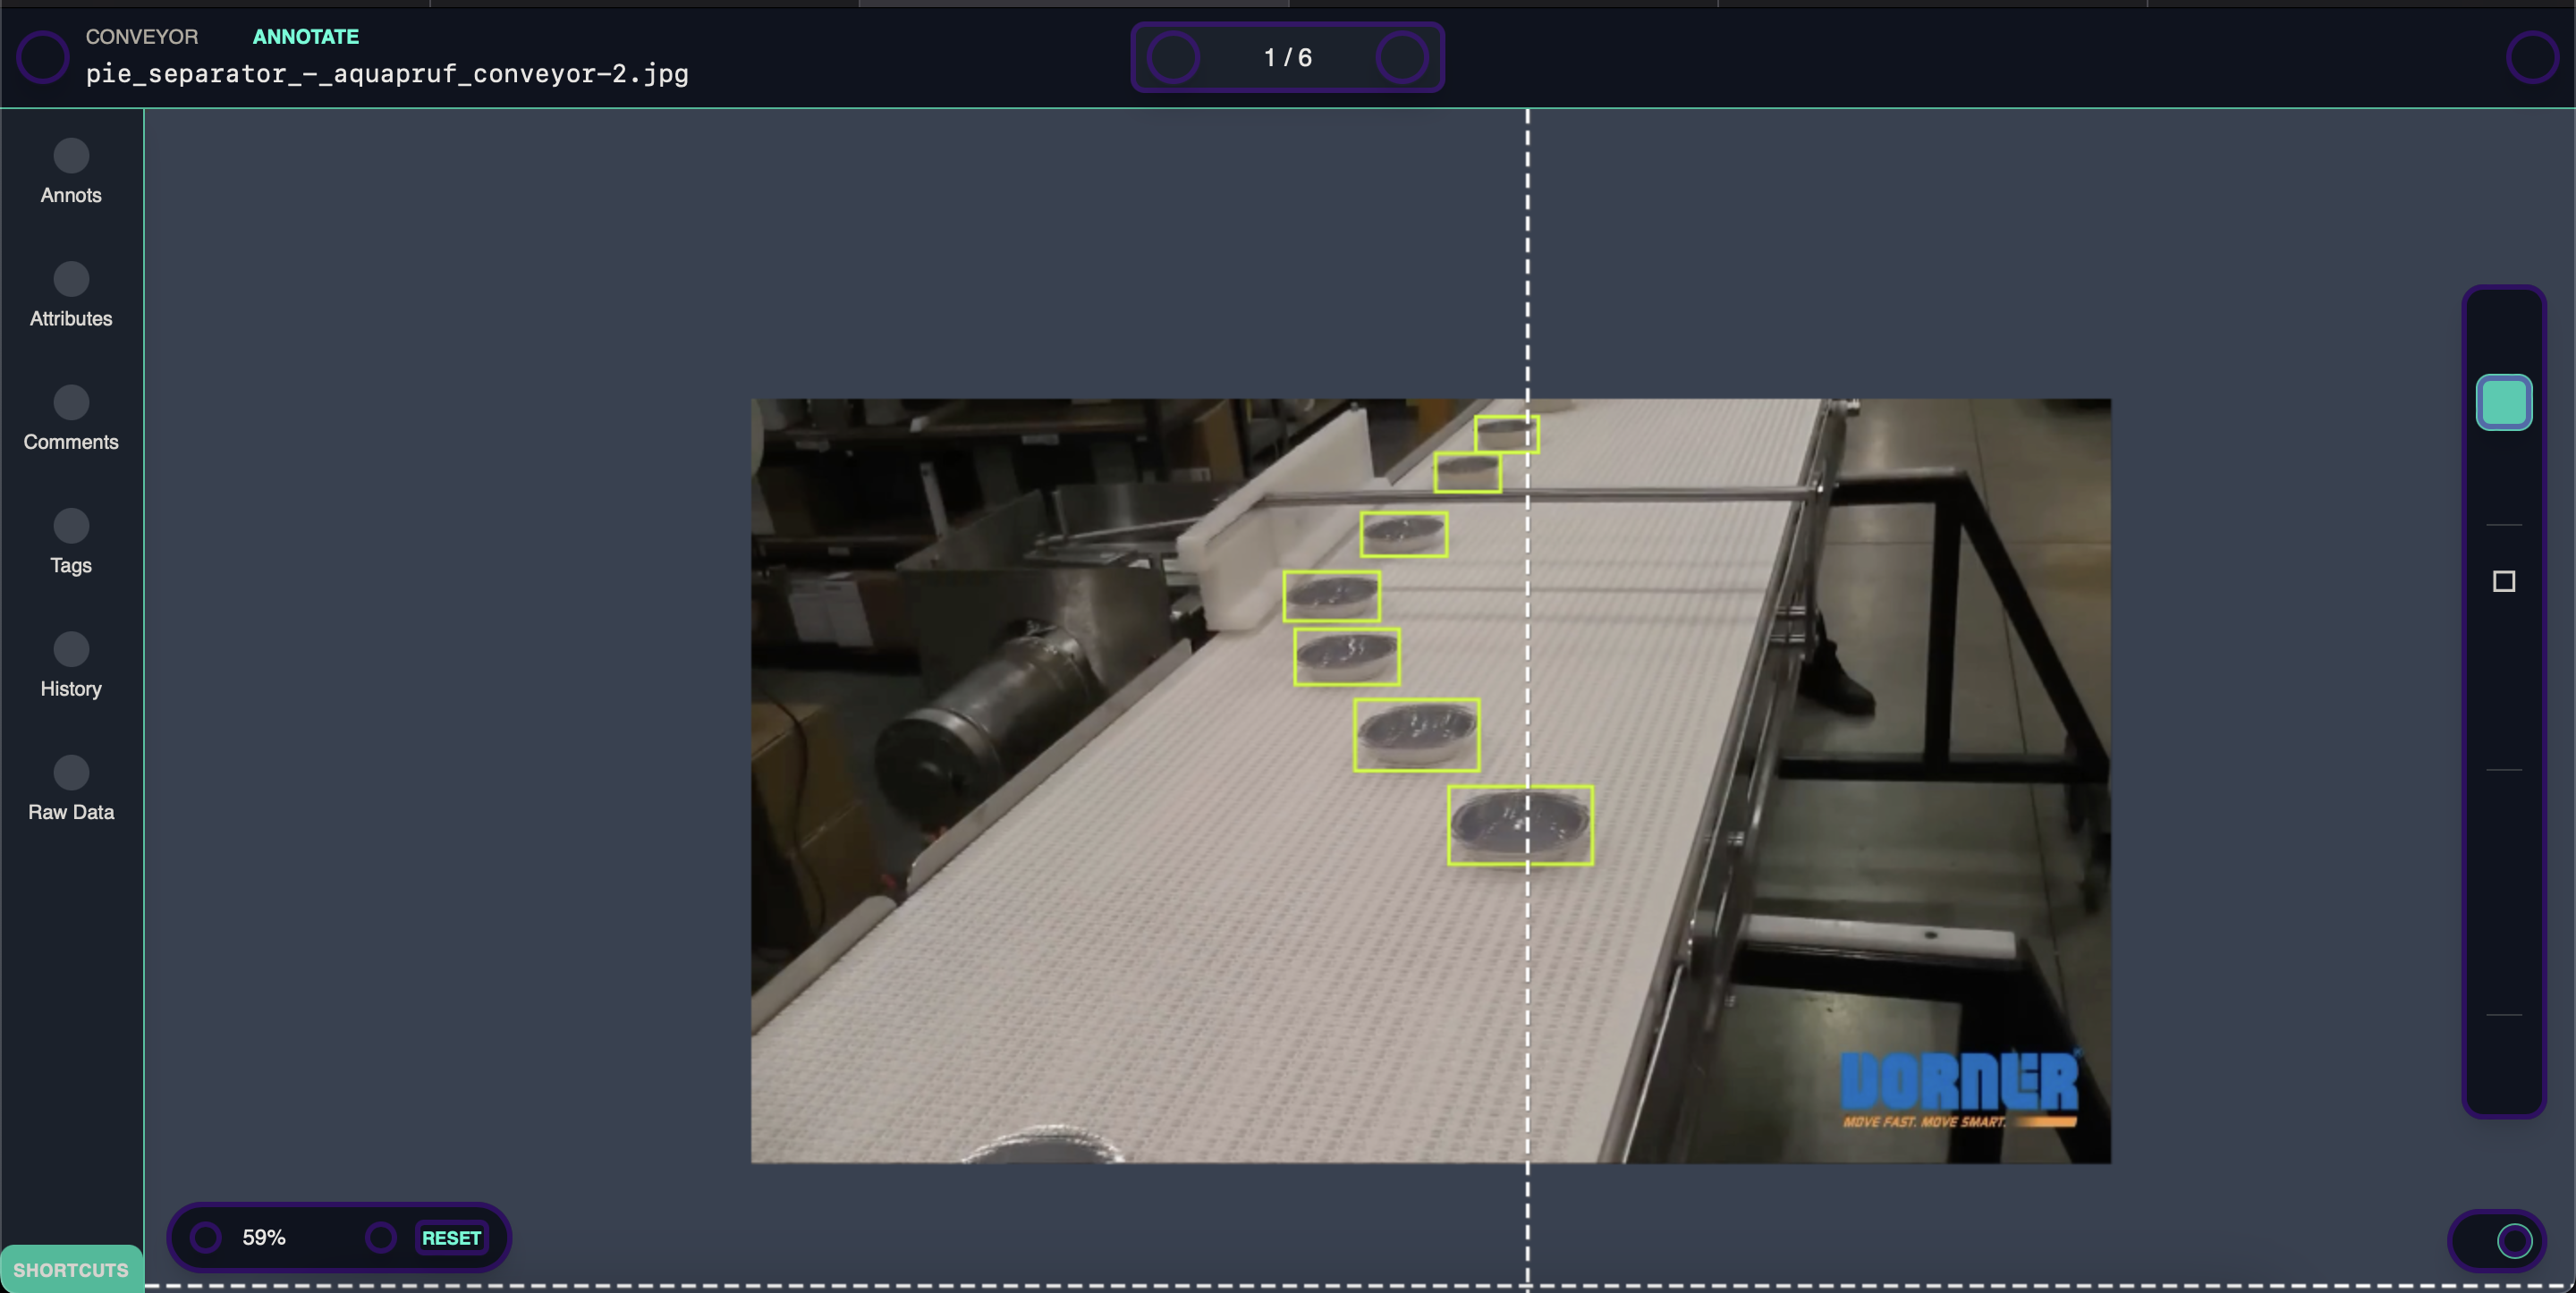

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/coursework_1/annotate.png')

[Ссылка на мой dataset на сайте roboflow](https://app.roboflow.com/university-6pxjn/conveyor-z8voo/1)

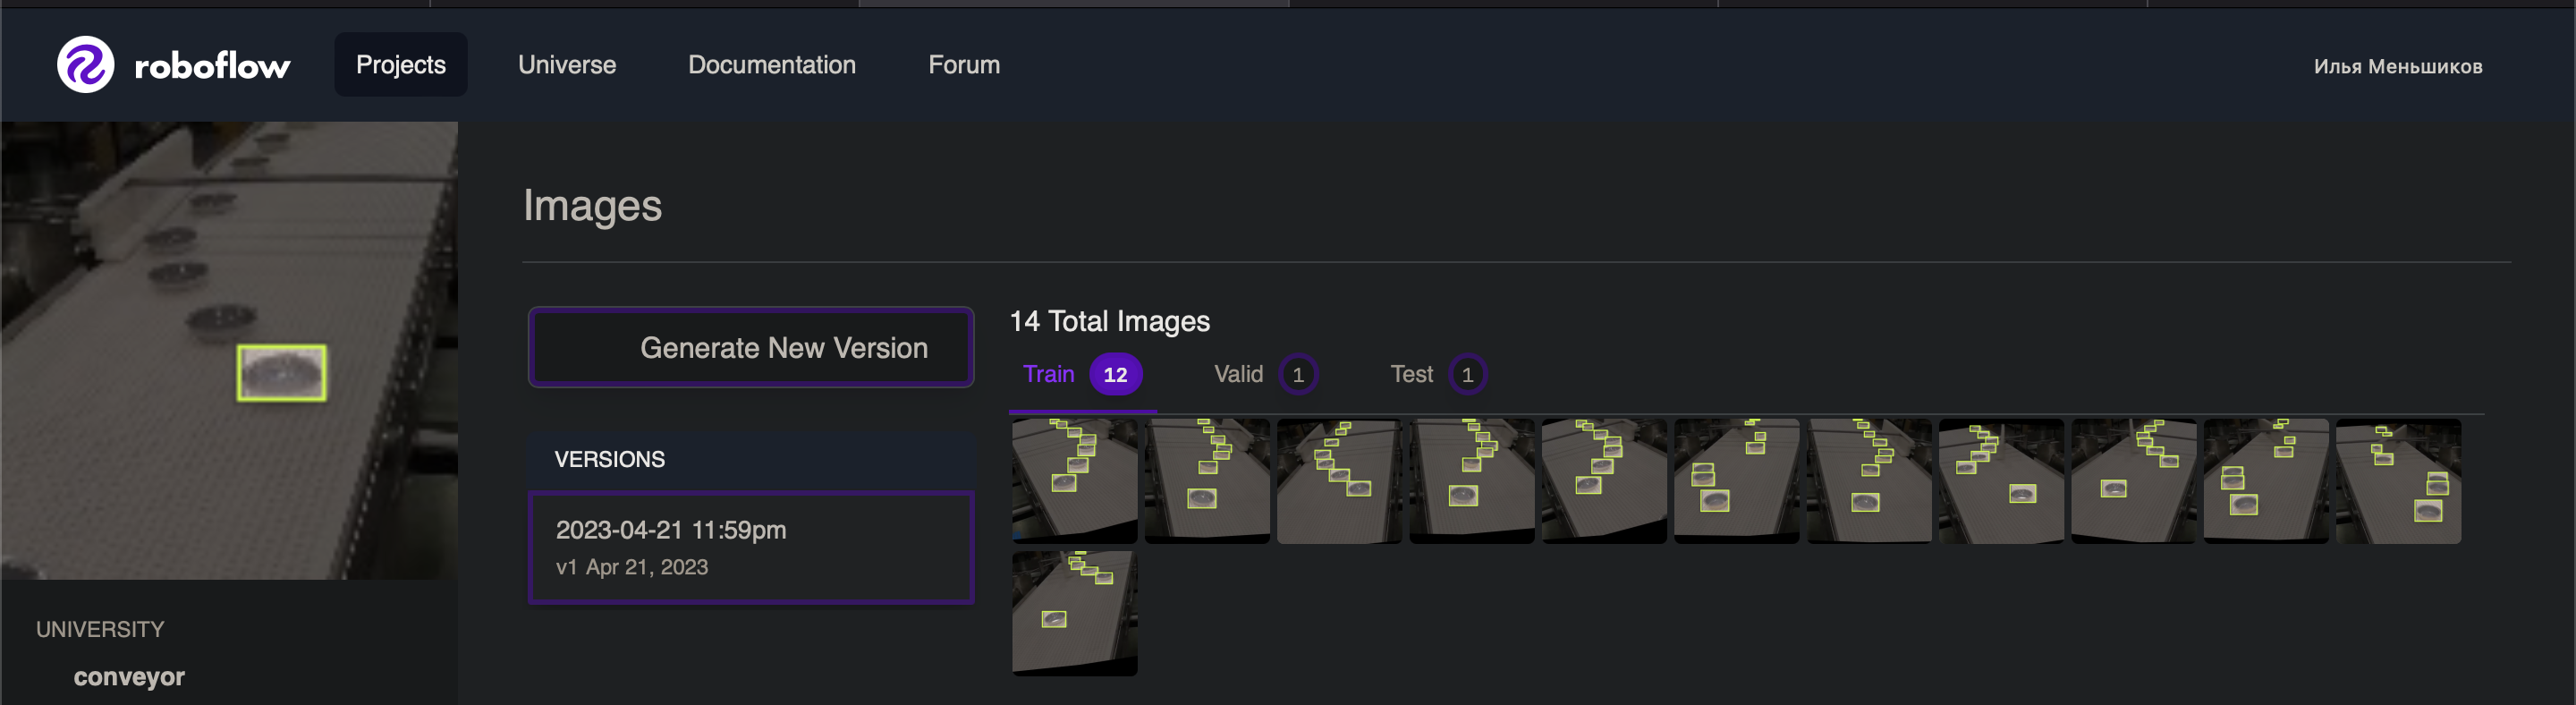

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/coursework_1/dataset.png')

In [ ]:
!pip install roboflow -q

from roboflow import Roboflow
rf = Roboflow(api_key="JmawvUYSWqVxUncv8pVM")
project = rf.workspace("university-6pxjn").project("conveyor-z8voo")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.84, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to conveyor-1 in yolov8:: 100%|██████████| 40/40 [00:00<00:00, 184.78it/s]


## Обучение модели

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8x.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

# epochs - количество эпох обучения, задает сколько раз датасет будет пропущен через нейронную сеть для ее обучения;
# Для каждой эпохи выводятся следующие метрики:
# - "box_loss" - ошибка обнаружения объектов
# - "cls_loss" - ошибка классификации объектов
# - "dfl_loss" - ошибка определения ориентации объектов
# - "Instances" - количество обнаруженных объектов
# - "Size" - размер изображения

/content/drive/MyDrive/coursework_1
100% 131M/131M [00:01<00:00, 91.4MB/s]
Ultralytics YOLOv8.0.84 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/coursework_1/conveyor-1/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, reti

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					     results.csv
confusion_matrix.png				     results.png
events.out.tfevents.1682111054.278bcb87dd7a.18402.0  train_batch0.jpg
F1_curve.png					     train_batch1.jpg
labels_correlogram.jpg				     train_batch2.jpg
labels.jpg					     val_batch0_labels.jpg
P_curve.png					     val_batch0_pred.jpg
PR_curve.png					     weights
R_curve.png


## Тесты модели

**Confusion matrix (матрица ошибок)** представляет собой таблицу, которая используется для оценки качества классификатора. Матрица ошибок имеет четыре ячейки: True Positive (TP), False Positive (FP), False Negative (FN) и True Negative (TN).

В данной матрице ошибок значения в первой строке равны единице, а значения во второй строке равны нулю, это означает, что классификатор не допустил ни одной ошибки первого рода (false positive), то есть все объекты, которые на самом деле принадлежали к классу pie, были правильно классифицированы как класс pie.


/content/drive/MyDrive/coursework_1


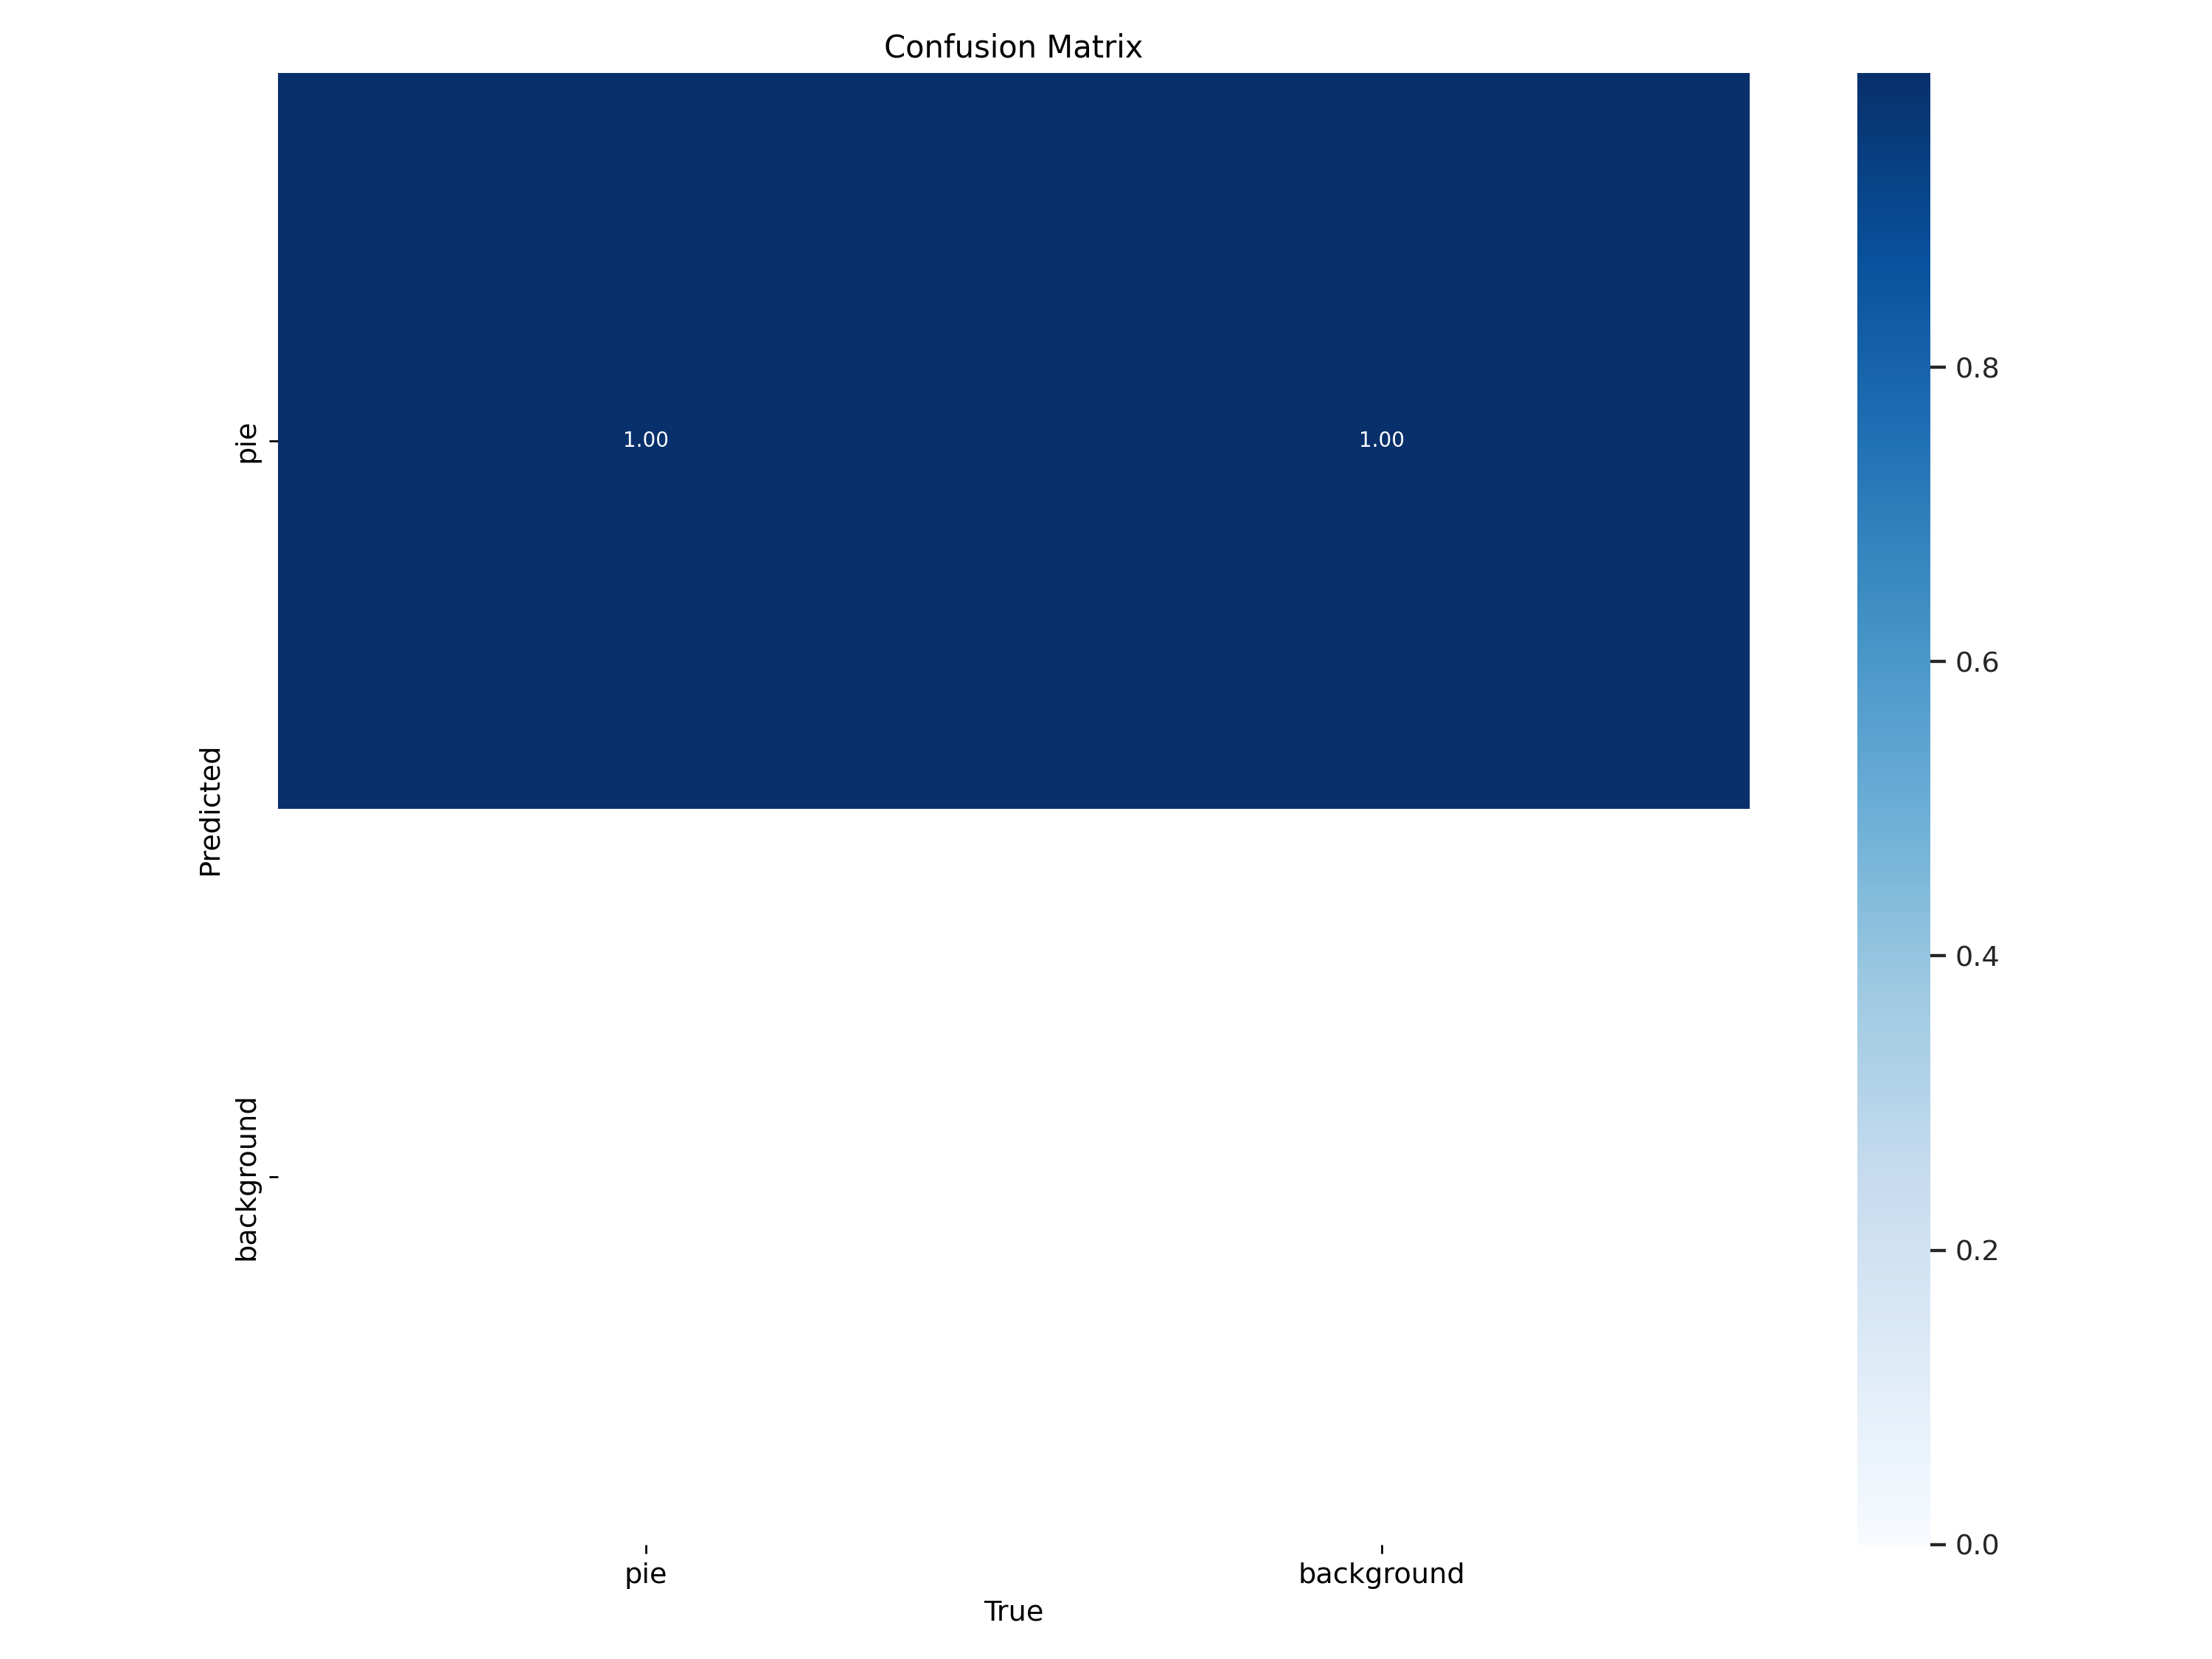

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

**График "box_loss"** показывает, как уменьшается ошибка обнаружения объектов в процессе обучения модели. Чем ниже значение функции потерь, тем лучше работает модель.

**График "cls_loss"** показывает, как уменьшается ошибка классификации объектов в процессе обучения модели. Чем ниже значение функции потерь, тем лучше работает модель.

**График "precision"** показывает, как точно модель определяет положительные классы. Precision (точность) измеряет отношение верно классифицированных объектов положительного класса к общему числу объектов, которые модель отнесла к этому классу. Высокое значение precision означает, что модель дает меньше ложных срабатываний, то есть меньше объектов, которые модель неправильно классифицировала как объекты положительного класса.


**График "recall"** показывает, как полно модель обнаруживает положительные классы. Recall (полнота) измеряет отношение верно классифицированных объектов положительного класса к общему числу объектов положительного класса в наборе данных. Высокое значение recall означает, что модель обнаруживает большое количество объектов положительного класса и имеет меньше ложных отрицательных результатов.

**График "mAP50"** (средняя точность обнаружения объектов при пороговом значении IoU=0.5) показывает, как хорошо модель обнаруживает объекты при определенном пороговом значении IoU. mAP50 рассчитывается путем усреднения точности (precision) на нескольких пороговых значениях IoU от 0 до 0.5. Чем выше значение mAP50, тем лучше работает модель.

**График "mAP50-95"** (средняя точность обнаружения объектов при пороговых значениях IoU от 0.5 до 0.95) показывает, как хорошо модель обнаруживает объекты при более высоких пороговых значениях IoU. mAP50-95 рассчитывается путем усреднения точности (precision) на пороговых значениях IoU от 0.5 до 0.95 с шагом 0.05. Чем выше значение mAP50-95, тем лучше работает модель.





/content/drive/MyDrive/coursework_1


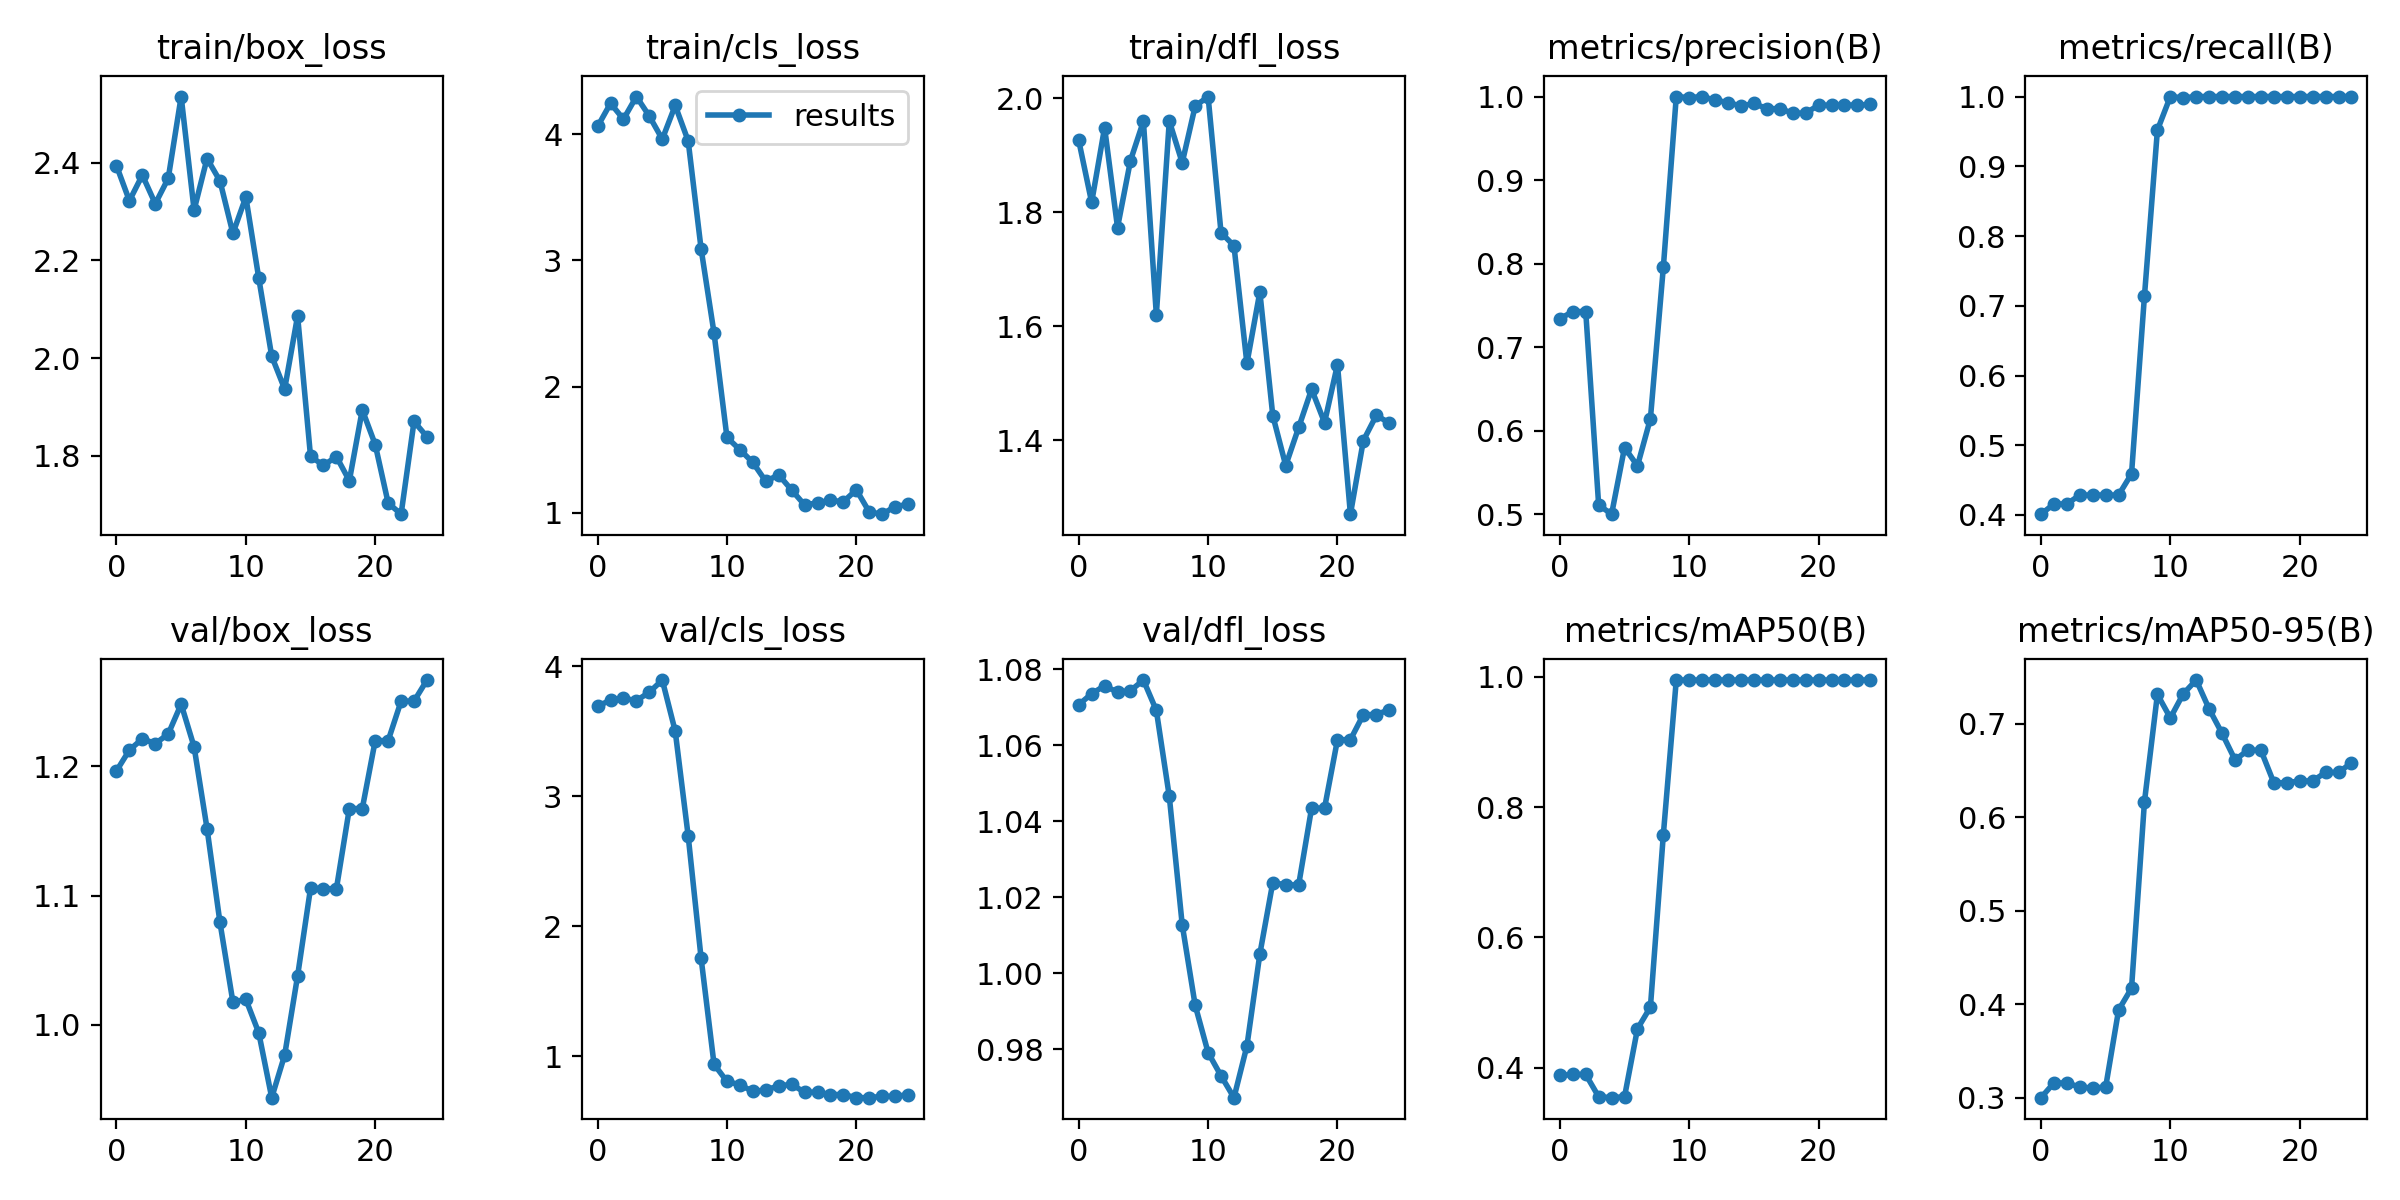

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content/drive/MyDrive/coursework_1


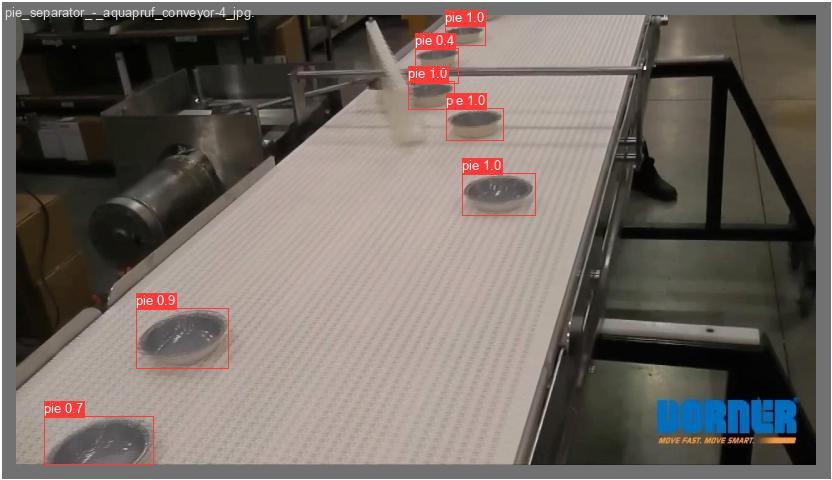

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Проверка модели на одном кадре

In [ ]:
MODEL = "runs/detect/train/weights/best.pt"

In [ ]:
model = YOLO(MODEL)
model.fuse()

Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs


In [ ]:
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [0]


0: 480x800 12 pies, 91.1ms
Speed: 0.6ms preprocess, 91.1ms inference, 1.8ms postprocess per image at shape (1, 3, 800, 800)


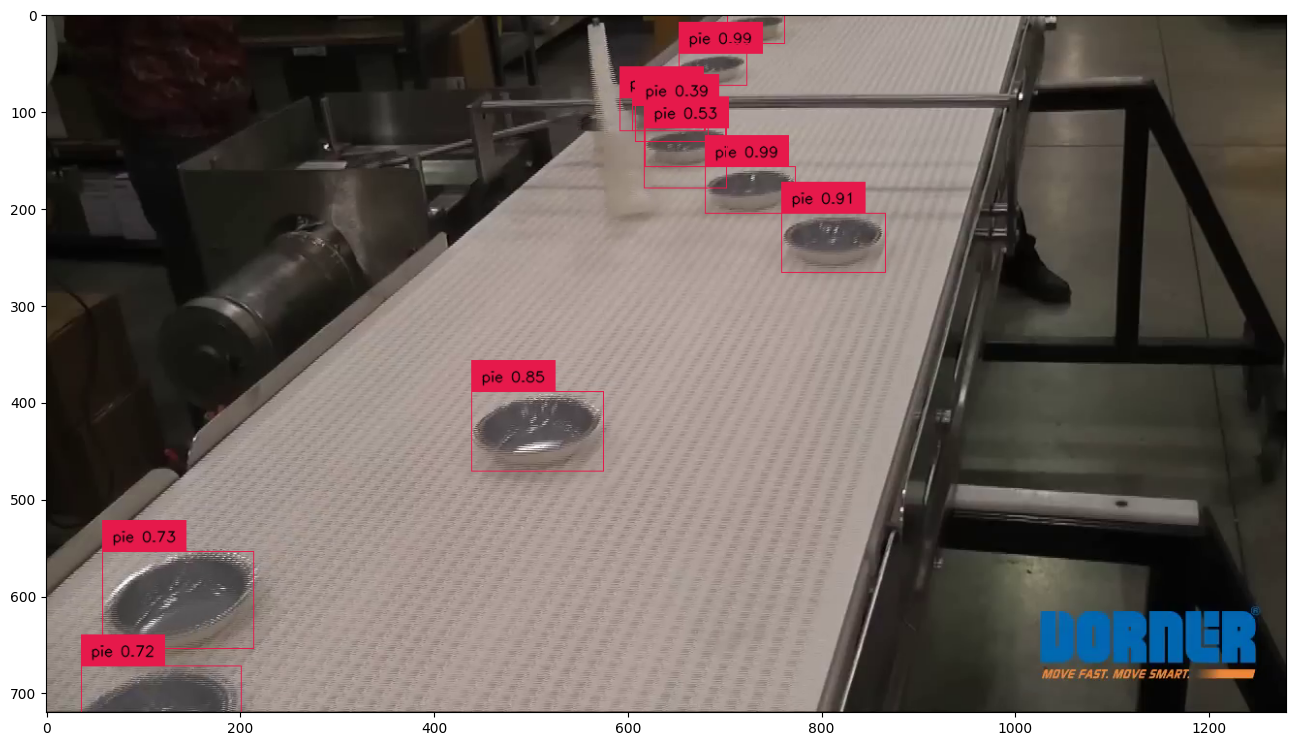

In [ ]:
# генератор кадров
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# ограничивающие рамки
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.5)

# получение первого кадра в видео
iterator = iter(generator)
frame = next(iterator)

# model prediction on single frame and conversion to supervision Detections
results = model(frame)

detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# изменение отображение меток
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# аннотация и отображение рамки
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Применение модели для всего видео

In [ ]:
LINE_START = Point(100, 500)
LINE_END = Point(800, 550)

TARGET_VIDEO_PATH = f"{HOME}/conveyor-result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=25, total_frames=155)

In [ ]:
from tqdm.notebook import tqdm


byte_tracker = BYTETracker(BYTETrackerArgs())
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# создание генератора кадров
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

line_counter = LineCounter(start=LINE_START, end=LINE_END)

# создание экземпляров BoxAnnotator и LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.3)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=1, text_scale=0.5)

# открытие видео
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # цикл по кадрам видео
    for frame in tqdm(generator, total=video_info.total_frames):
        # предсказание модели на одном кадре и преобразование в supervision
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # фильтрация обнаружений с нежелательными классами
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # отслеживание обнаружений
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # фильтрация
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # изменение отображение меток
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # обновление счетчика строк
        line_counter.update(detections=detections)

        # аннотировать и отображать кадр
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)
display.clear_output()

[Ссылка на результат, загруженный на Google Drive](https://drive.google.com/file/d/18KZ5MH93xfLoOmntxJX4aD-bOXHEPK4S/view?usp=share_link)

## Вывод части результата

In [ ]:
#создание gif из mp4
from moviepy.editor import VideoFileClip

videoClip = VideoFileClip("/content/drive/MyDrive/coursework_1/conveyor-result.mp4")

videoClip.write_gif("/content/drive/MyDrive/coursework_1/conveyor-result.gif")

MoviePy - Building file /content/drive/MyDrive/coursework_1/conveyor-result.gif with imageio.


[Ссылка на результат в формате gif](https://drive.google.com/file/d/18LqXEx1lifxwJ_CCrZOWPm8XADvdxM72/view?usp=share_link)

In [ ]:
from matplotlib import rcParams
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Лимит на вход 30 MB
rcParams['animation.embed_limit'] = 30.0

# Получение gif и разбиение по слайдам
gif_path = '/content/drive/MyDrive/coursework_1/conveyor-result.gif'
gif = Image.open(gif_path)
frames = []
for i in range(gif.n_frames):
    gif.seek(i)
    frame = gif.copy()
    frames.append(frame)

# Функция анимации
def create_animation(ims):

    fig = plt.figure(figsize=(10, 6))
    plt.axis('off')
    im = plt.imshow(ims[0])
    plt.close()

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000//4)

animation_obj = create_animation(frames)

# Отображение gif по слайдам
HTML(animation_obj.to_jshtml())

# Вывод

В результате работы я изучил новые методы машинного обучения, такие как алгоритмы  YOLOv8, ByteTrack и Roboflow Supervision для обнаружения паттернов в видео. Также я разобрался, как создавать аннотации для пользовательских данных, и на их основе обучать и тестировать модель.

После обучения YOLOv8 на пользовательском наборе данных были достигнуты высокие результаты, что подтверждает эффективность данного подхода для обработки видео и обнаружения паттернов. Они могут быть использованы в различных областях, где обработка видео является ключевой задачей.


## Сравнение разных моделей